Rows (raw):  Tor = 30526  Non-Tor = 5350
Non-Tor: kept 9828 / 10589 after outlier removal (removed 761)
Tor    : kept 53387 / 56681 after outlier removal (removed 3294)
Welch’s t-test P-value: 0
Mean Jitter - Non-Tor: 0.403 ms
Mean Jitter - Tor    : 42.875 ms
Mean Difference (Tor - Non-Tor): 42.472 ms


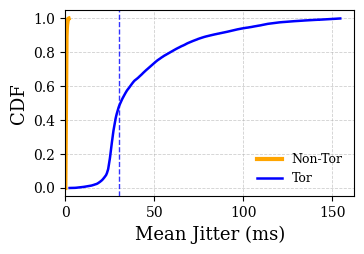

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from matplotlib import rcParams

# === CONFIGURE FOR ACADEMIC QUALITY ===
rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 13,
    "axes.titlesize": 14,
    "legend.fontsize": 9,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "pdf.fonttype": 42,
})

# === FILE PATHS ===
file_non_tor = "../../data/final-non-tor.csv"
file_tor = "../../data/final-tor.csv"

# === READ DATA ===
df_non_tor = pd.read_csv(file_non_tor)
df_tor = pd.read_csv(file_tor)

print("Rows (raw):  Tor =", len(df_tor), " Non-Tor =", len(df_non_tor))

# ---------- CLEANING HELPERS ----------
def to_clean_numeric(series):
    """Coerce to numeric, drop NaN/inf/-inf, and keep non-negative values."""
    s = pd.to_numeric(series, errors='coerce')
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    s = s[s >= 0]  # jitter shouldn't be negative
    return s

def remove_extreme_outliers(series, k=3.0):
    """Remove extreme outliers via IQR rule."""
    series = np.asarray(series)
    if series.size == 0:
        return series, 0
    q1, q3 = np.percentile(series, [25, 75])
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    before = series.size
    filtered = series[(series >= lower) & (series <= upper)]
    removed = before - filtered.size
    return filtered, removed

# === COMBINE CALLER + CALLEE JITTER MEANS, CLEAN, OUTLIER FILTER ===
# Non-Tor
non_tor_raw = pd.concat([
    to_clean_numeric(df_non_tor['caller_jitter_mean']),
    to_clean_numeric(df_non_tor['callee_jitter_mean'])
], ignore_index=True)
non_tor_clean, non_tor_out_rm = remove_extreme_outliers(non_tor_raw, k=3.0)

# Tor
tor_raw = pd.concat([
    to_clean_numeric(df_tor['caller_jitter_mean']),
    to_clean_numeric(df_tor['callee_jitter_mean'])
], ignore_index=True)
tor_clean, tor_out_rm = remove_extreme_outliers(tor_raw, k=3.0)

print(f"Non-Tor: kept {len(non_tor_clean)} / {len(non_tor_raw)} after outlier removal (removed {non_tor_out_rm})")
print(f"Tor    : kept {len(tor_clean)} / {len(tor_raw)} after outlier removal (removed {tor_out_rm})")

# === CDF FUNCTION ===
def compute_cdf(data):
    data = np.asarray(data, dtype=float)
    if data.size == 0:
        return np.array([]), np.array([])
    sorted_data = np.sort(data)
    yvals = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    return sorted_data, yvals

non_tor_sorted, non_tor_cdf = compute_cdf(non_tor_clean)
tor_sorted, tor_cdf = compute_cdf(tor_clean)

# === STATISTICAL TEST (Welch’s t-test) ===
if len(tor_clean) > 1 and len(non_tor_clean) > 1:
    stat, p_value = ttest_ind(tor_clean, non_tor_clean, equal_var=False)
    mean_diff = np.mean(tor_clean) - np.mean(non_tor_clean)
else:
    p_value = np.nan
    mean_diff = np.nan

# === PRINT RESULTS ===
print("Welch’s t-test P-value:", "NA" if np.isnan(p_value) else f"{p_value:.4g}")
print(f"Mean Jitter - Non-Tor: {np.nanmean(non_tor_clean):.3f} ms")
print(f"Mean Jitter - Tor    : {np.nanmean(tor_clean):.3f} ms")
print(f"Mean Difference (Tor - Non-Tor): {mean_diff:.3f} ms")

# === PLOT CDF ===
fig, ax = plt.subplots(figsize=(3.8, 2.7))  # small 1-col friendly

if len(non_tor_sorted) > 0:
    ax.plot(non_tor_sorted, non_tor_cdf,
            label="Non-Tor",
            linewidth=3.0,    # thicker for visibility
            color="orange",
            linestyle="-")

if len(tor_sorted) > 0:
    ax.plot(tor_sorted, tor_cdf,
            label="Tor",
            linewidth=1.8,
            color="blue",
            linestyle="-")

# Threshold line (optional)
ax.axvline(x=30, linestyle='--', color='blue', linewidth=1.0, alpha=0.8)

ax.set_xlabel("Mean Jitter (ms)")
ax.set_ylabel("CDF")

# Autoscale x to filtered data max with a little headroom
xmax_candidates = []
if len(non_tor_sorted) > 0:
    xmax_candidates.append(non_tor_sorted.max())
if len(tor_sorted) > 0:
    xmax_candidates.append(tor_sorted.max())
xmax = max(xmax_candidates) if xmax_candidates else 1.0
ax.set_xlim(0, 1.05 * xmax)

ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)
ax.legend(loc="lower right", fontsize=9, frameon=False)

plt.tight_layout()
plt.savefig("jitter_mean_cdf.pdf", dpi=300, bbox_inches="tight", transparent=True)
plt.show()


In [10]:
import numpy as np

# === Compute statistics ===
mean_non_tor = np.mean(non_tor_clean)
mean_tor = np.mean(tor_clean)
abs_diff = mean_tor - mean_non_tor
ratio = mean_tor / mean_non_tor if mean_non_tor > 0 else np.nan

def exceed_percentage(data, threshold):
    return (np.sum(np.array(data) > threshold) / len(data)) * 100 if len(data) > 0 else np.nan

# Threshold exceedance
tor_gt10 = exceed_percentage(tor_clean, 10)
tor_gt20 = exceed_percentage(tor_clean, 20)
tor_gt30 = exceed_percentage(tor_clean, 30)

non_gt10 = exceed_percentage(non_tor_clean, 10)
non_gt30 = exceed_percentage(non_tor_clean, 30)

# === Print results ===
print(f"The mean jitter for Non-Tor calls is {mean_non_tor:.2f} ms, "
      f"while Tor-based calls exhibit a mean jitter of {mean_tor:.2f} ms.")
print(f"This represents a {ratio:.1f}x increase, with an absolute difference of {abs_diff:.2f} ms.\n")

print(f"Nearly {tor_gt10:.0f}% of Tor calls exceed 10 ms "
      "(where adaptive jitter buffers start introducing latency and reordering).")
print(f"Over {tor_gt20:.0f}% of Tor calls exceed 20 ms, "
      f"and about {tor_gt30:.0f}% cross the 30 ms threshold (hurting interactivity).\n")

print(f"In contrast, Non-Tor calls remain very stable: "
      f"only {non_gt10:.2f}% exceed 10 ms, and less than {non_gt30:.2f}% exceed 30 ms.\n")

print("Earlier works reported jitter values of only 15–20 ms.")


The mean jitter for Non-Tor calls is 0.40 ms, while Tor-based calls exhibit a mean jitter of 42.87 ms.
This represents a 106.4x increase, with an absolute difference of 42.47 ms.

Nearly 99% of Tor calls exceed 10 ms (where adaptive jitter buffers start introducing latency and reordering).
Over 96% of Tor calls exceed 20 ms, and about 52% cross the 30 ms threshold (hurting interactivity).

In contrast, Non-Tor calls remain very stable: only 0.00% exceed 10 ms, and less than 0.00% exceed 30 ms.

Earlier works reported jitter values of only 15–20 ms.


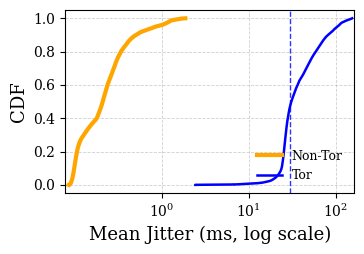

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# === Compute CDF function ===
def compute_cdf(data):
    data = np.asarray(data, dtype=float)
    if data.size == 0:
        return np.array([]), np.array([])
    x = np.sort(data)
    y = np.arange(1, x.size+1) / x.size
    return x, y

non_tor_x, non_tor_y = compute_cdf(non_tor_clean)
tor_x, tor_y = compute_cdf(tor_clean)

# === Plot CDF with log-scaled x-axis ===
fig, ax = plt.subplots(figsize=(3.8, 2.7))

if non_tor_x.size:
    ax.plot(non_tor_x, non_tor_y, label="Non-Tor",
            linewidth=3.0, color="orange")

if tor_x.size:
    ax.plot(tor_x, tor_y, label="Tor",
            linewidth=1.8, color="blue")

# Threshold line at 30 ms
ax.axvline(x=30, linestyle='--', color='blue', linewidth=1.0, alpha=0.8)

ax.set_xscale("symlog", linthresh=1.0)  # log scale, but linear inside ±1 ms
ax.set_xlim(left=0.001)  # avoid log(0)

ax.set_xlabel("Mean Jitter (ms, log scale)")
ax.set_ylabel("CDF")
ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.6, which="both")
ax.legend(loc="lower right", fontsize=9, frameon=False)

plt.tight_layout()
plt.savefig("jitter_mean_cdf_log.pdf", dpi=300, bbox_inches="tight", transparent=True)
plt.show()
